In [ ]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

from tqdm import tqdm

In [ ]:
def genOneHotkey(hotkey_position, num_class):
  oneHotkey = []
  
  for i in range(num_class):
    if i ==  hotkey_position:
      oneHotkey.append(1)
    else:
      oneHotkey.append(0)

  return oneHotkey

In [ ]:
def imagesToDatas(image_path_list, image_width, index_of_classname,):
  dataImages = []
  oneHotkeys = []

  num_class = len(image_path_list)

  classnameToHotkeyPosition = dict()
  hotkeyCount = 0

  for path in image_path_list:

      classname = path.split('/')[index_of_classname]

      if classname not in classnameToHotkeyPosition.keys():
        classnameToHotkeyPosition[classname] = hotkeyCount
        hotkeyCount+=1

      for item in tqdm(os.listdir(path)):
          file_path = os.path.join(path, item)

          if os.path.isfile(file_path):
            dataImage = cv2.imread(file_path,cv2.cv2.COLOR_BGR2RGB)

            # Convert Gray sys. image to RGB sys.
            if len(dataImage.shape) == 2:
                dataImage = cv2.cvtColor(dataImage, cv2.COLOR_GRAY2RGB)
       
            dataImage = cv2.resize(dataImage,(image_width,image_width))

            dataImages.append(dataImage)
            oneHotkeys.append(genOneHotkey(classnameToHotkeyPosition[classname],num_class))

  return dataImages, oneHotkeys, num_class

In [ ]:
path_dataset = os.path.join(os.getcwd(),'drive','MyDrive','Colab Notebooks','dataset')

dataset_image_path_list = list(filter(os.path.isdir, list(map(path_dataset.__add__, map('/'.__add__, os.listdir(path_dataset))))))
dataset_image_path_list.sort()

print('dataset_image_path_list : {} '.format(dataset_image_path_list))

In [ ]:
image_width = 128

# **Data Collection**



In [ ]:
x, y, num_class = imagesToDatas(dataset_image_path_list, image_width, 6)

print('\n')
print('number of class : {}'.format(num_class))
print('y (oneHotkey) : {}'.format(y))

# **Data Preprocessing**



In [ ]:
x = np.array(x)
y = np.array(y)

# Preprocessing data for Xception model
x = tf.keras.applications.xception.preprocess_input(x)

print('x shape : {}'.format(x.shape))
print('y shape : {}'.format(y.shape))

# **Data Spliting**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))

# **Create Neural Network**

In [ ]:
# Create base model from Xception
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_width,image_width,3),
    pooling='avg',
)

# Freeze base model
base_model.trainable = False

# Create new model by merging base model with some layers
model = keras.Sequential([
        base_model,

        keras.layers.Flatten(),
        keras.layers.Dense(num_class, activation='softmax')   # use softmax for one hot  / use sigmoid for [0/1]
    ])

model.build((None,image_width,image_width,3))
model.summary()

# **Choose Optimizer**

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics= ['accuracy'])

# **Model Training**



In [ ]:
batch_size = 32
epochs = 30

history = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

# **Model Evaluation**


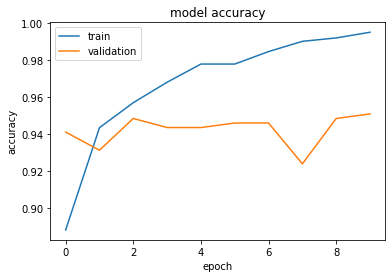

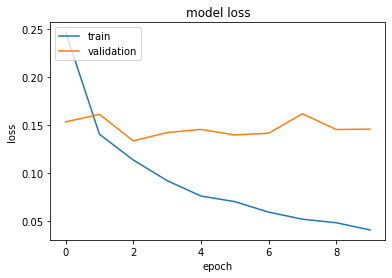

In [ ]:
#Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Model Saving**

In [ ]:
model.save(os.path.join(os.getcwd(),'drive','MyDrive','Colab Notebooks','model'))